In [1]:
# Comparison to GSTools

# Cover 4 cases: 
# 1) No nugget effect, data points off grid
# 2) No nugget effect, data points on grid
# 3) Nugget effect, data points off grid
# 4) Nugget effect, data points on grid

# Make it nice, Plot 3d and variance for each example. Plot gstools with viridis colormap and same scale

###  1) Creating a simple GemPy model

In a first step we create a simple GemPy model consisting of a basement and two units named "rock1" and "rock2". The layering is completetely horizontal and while model is theoretically 3D, we only have a single point depth in y driection, basically creating a single 2D cross-section. For a more detailed description take a look at the GemPy tutorials.

In [2]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")
# Importing GemPy
import gempy as gp
# Embedding matplotlib figures in the notebooks
%matplotlib inline
# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
# import the kriging module
import importlib
from gempy.assets import kriging

In [3]:
# set resolution, extent and input data
geo_data = gp.create_data([0,1000,0,50,0,1000],resolution=[50,1,50], 
                        path_o = os.pardir+"/data/input_data/jan_models/model1_orientations.csv",
                        path_i = os.pardir+"/data/input_data/jan_models/model1_surface_points.csv") 

Active grids: ['regular']


In [4]:
# define series and assign surfaces
gp.map_series_to_surfaces(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')})

,surface,series,order_surfaces,isBasement,color,id
0,rock2,Strat_Series,1,False,#015482,1
1,rock1,Strat_Series,2,False,#9f0052,2
2,basement,Basement_Series,1,True,#ffbe00,3


In [5]:
# define the interpolator
interp_data = gp.set_interpolation_data(geo_data, compile_theano=True,
                                        theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!


In [6]:
#calcualte the solution
sol = gp.compute_model(geo_data)

../..\gempy\core\solution.py:258: UserWarning: Surfaces not computed due to: marching_cubes_lewiner() got an unexpected keyword argument 'mask'
  warnings.warn('Surfaces not computed due to: ' + str(e))


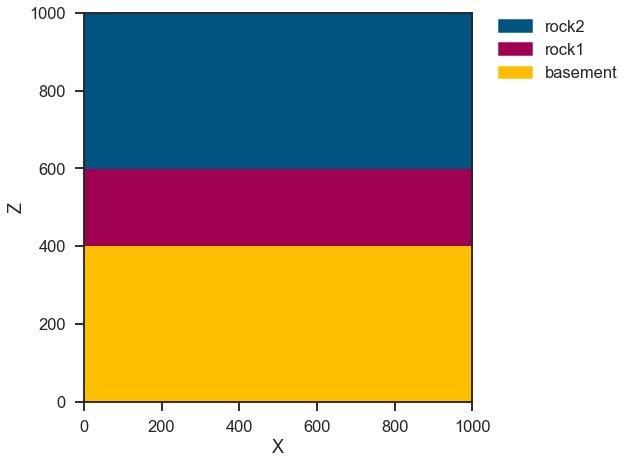

In [7]:
# Plot cross section, which is basically the whole model in this example
gp.plot.plot_section(geo_data, cell_number=0)

In [24]:
from gstools import krige
import gempy as gp
importlib.reload(kriging)

from gstools import SRF, Exponential
import matplotlib.pyplot as plt
import gstools as gs


In [41]:
#test_data = np.array([[100,.5,500,2],[900,.5,500,1],[500,.5,550,1],[300,.5,400,5]])
test_data = np.array([[110,0,510,2],[910,0,510,1],[510,0,530,1],[310,0,410,5]])

x_cond = test_data[:,0]
y_cond = test_data[:,2]
cond_val = test_data[:,3]
x = range(0,1000,20)
y = range(400,600,20)

np.var(cond_val)

2.6875

In [42]:
# Example with kriging in GemPy

In [43]:

# My calc:
kriging_model = kriging.kriging_model(model=sol, domain=[2],data=test_data)

kriging_model.krig_grid = np.round(kriging_model.krig_grid,0)

kriging_model.range_ = 200
kriging_model.moving_neighbourhood  = 'all'
kriging_model.set_kriging_type('OK')
kriging_model.nugget = 2
kriging_model.sill = np.var(cond_val)

kriging_model.create_kriged_field()
prop = kriging_model.results_df['est_value'].values
var = kriging_model.results_df['est_variance'].values

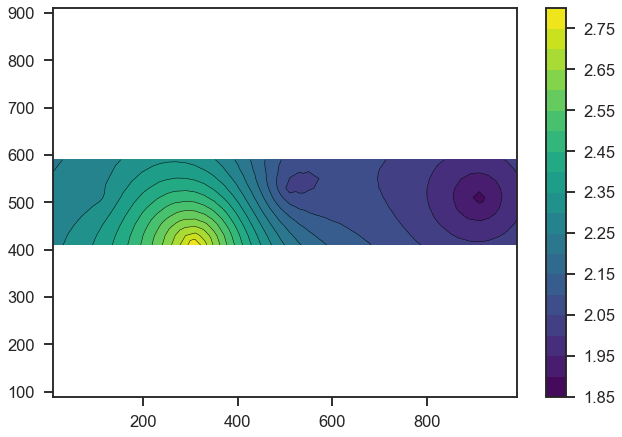

In [44]:
x = kriging_model.results_df['X'].values
y = kriging_model.results_df['Z'].values
prop = kriging_model.results_df['est_value'].values
var = kriging_model.results_df['est_variance'].values
fig1, ax1 = plt.subplots()
ax1.axis('equal')
tcf = ax1.tricontourf(x, y, prop, 20, cmap='viridis')
tcf_lines = ax1.tricontour(x, y, prop, 20, linewidths=0.5, colors='k')
fig1.colorbar(tcf)

plt.show()

In [45]:
print(np.max(prop))
print(np.min(prop))
print(np.mean(prop))

2.7982913552430766
1.8821964293170272
2.19922672679857


In [46]:
# Example with GSTools

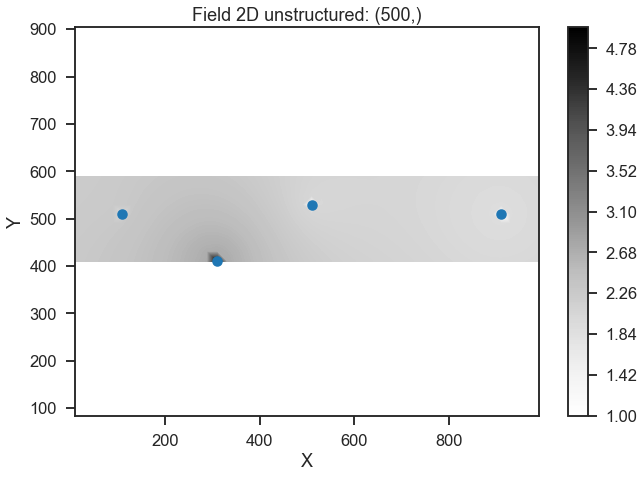

In [47]:
# Kriged field

# they use other sill - increase with nugget effect

model = Exponential(dim=2, var=np.var(cond_val)-2 , len_scale=200, nugget=2)

srf = krige.Ordinary(model, cond_pos=(x_cond, y_cond), cond_val=cond_val)
field = srf((x, y), mesh_type='unstructured')

fig, ax = plt.subplots()
ax.axis('equal')
srf.plot(fig=fig, ax=ax)
ax.scatter(x_cond, y_cond)

In [48]:
print(np.max(field[0]))
print(np.min(field[0]))
print(np.mean(field[0]))

5.000000000000001
0.9999999999999998
2.1992267267985697


In [49]:
print(field[0].shape)

(500,)


In [50]:
#kriging_model.krig_grid.shape

In [51]:
#srf.pos[0]

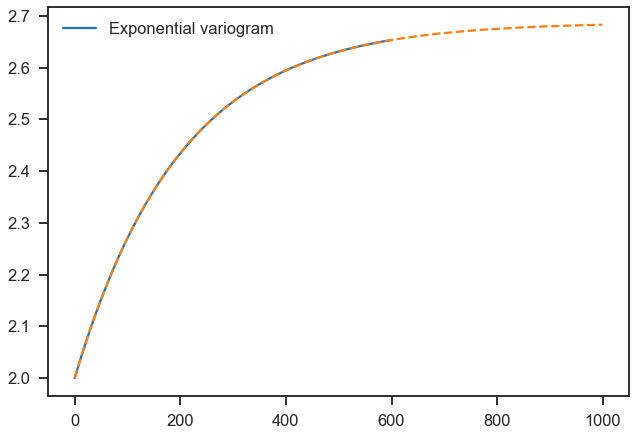

In [52]:
# Wow s varigoram exactly the same (sweet)
d = np.arange(0,1000,1)
test_vario = kriging_model.exponential_variogram_model(d)

fig, ax = plt.subplots()

gs.covmodel.plot.plot_variogram(model, ax=ax)
ax.plot(d, test_vario,'--')

In [53]:
from mpl_toolkits.mplot3d import Axes3D

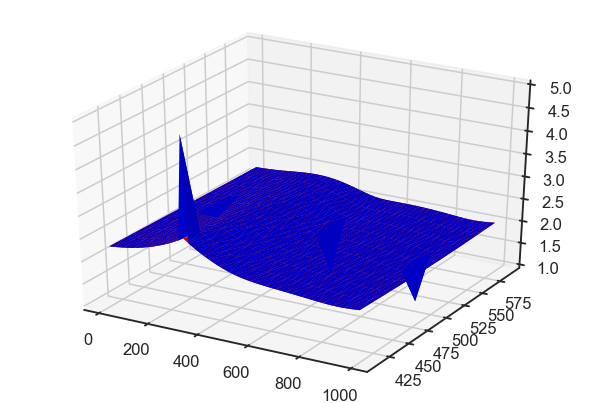

In [54]:
# Comparison as 3D surface plot:
Xs1 = kriging_model.results_df['X'].values
Ys1 = kriging_model.results_df['Z'].values
Zs1 = kriging_model.results_df['est_value'].values

Xs2 = srf.pos[0]
Ys2 = srf.pos[1]
Zs2 = field[0]

#Axes3D.plot_surface(X, Y, Z, *args, **kwargs)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(Xs2, Ys2, Zs2, color='blue', linewidth=0)
ax.plot_trisurf(Xs1, Ys1, Zs1, color='red', linewidth=0)

#fig.colorbar(surf1)

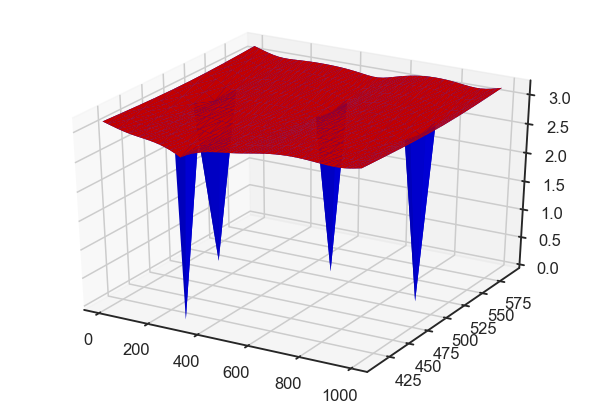

In [55]:
# Comparison as 3D surface plot:
Xs1 = kriging_model.results_df['X'].values
Ys1 = kriging_model.results_df['Z'].values
Zs1 = kriging_model.results_df['est_variance'].values

Xs2 = srf.pos[0]
Ys2 = srf.pos[1]
Zs2 = field[1]

#Axes3D.plot_surface(X, Y, Z, *args, **kwargs)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(Xs2, Ys2, Zs2, color='blue', linewidth=0)
ax.plot_trisurf(Xs1, Ys1, Zs1, color='red', linewidth=0)